In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator
from bbtoolkit.data.configparser import EvalConfigParser
import configparser
from typing import Any

In [2]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

['../cfg/connectivity/main.ini']

In [3]:
def connectivity_config2dict(config: EvalConfigParser) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section not in ('ExternalSources','Hyperparameters')
    }
    return out

In [4]:
configdict = connectivity_config2dict(config)

In [5]:
from bbtoolkit.structures.synapses import TensorGroup, dict2directed_tensor


connections = dict2directed_tensor(configdict)
weights = TensorGroup(*connections)

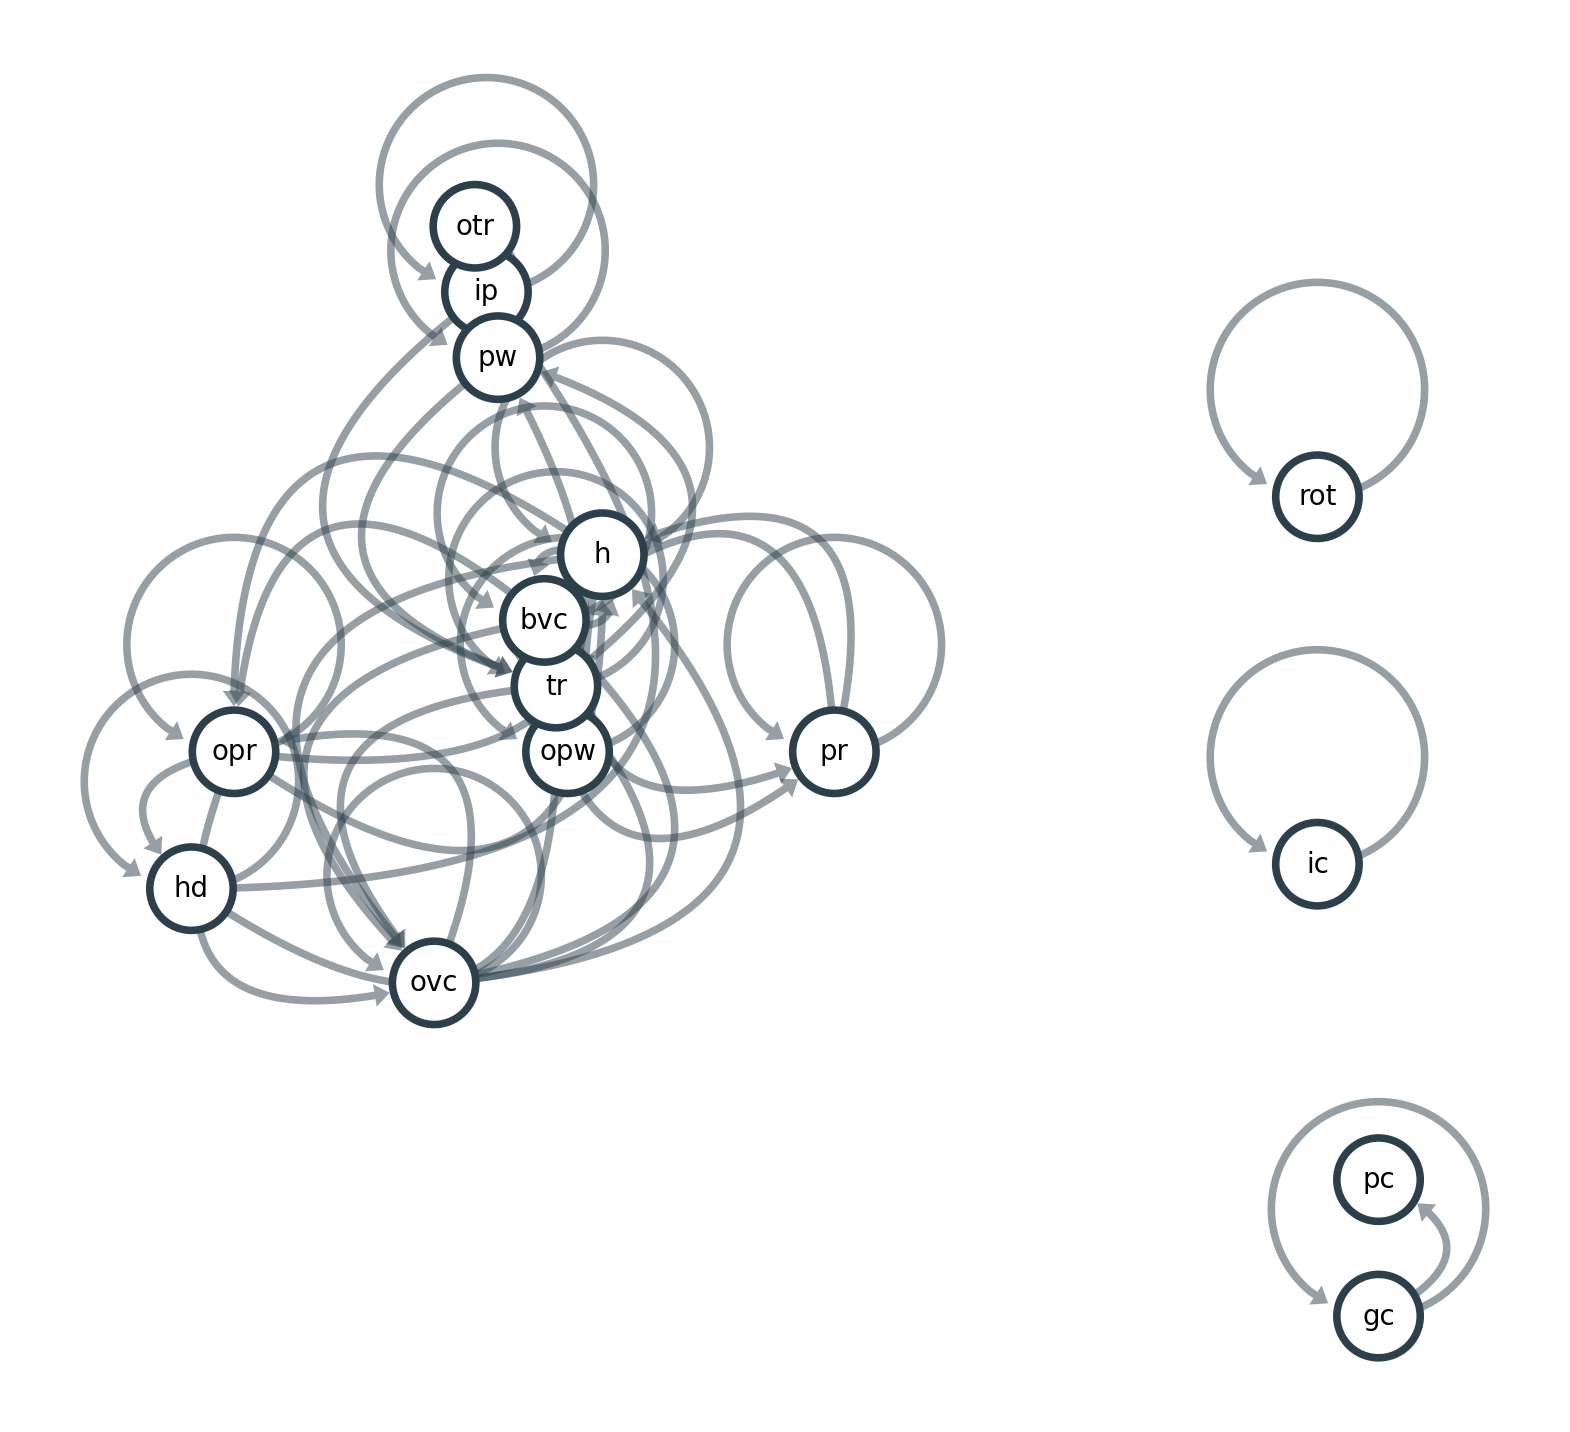

In [19]:
fig = weights.plot(edge_labels=False, node_layout='radial', edge_width=.5)

In [7]:
weights.connection_map

,ip,pw,opw,h,ic,pr,tr,rot,bvc,ovc,gc,opr,hd,pc,otr
ip,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
pw,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
opw,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
h,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0
ic,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
pr,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0
tr,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0
rot,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
bvc,0,0,0,1,0,1,1,0,1,1,0,1,0,0,0
ovc,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0


In [8]:
simconfig_path = '../cfg/simulation/one_one.ini'
simconfig = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
simconfig.read(simconfig_path)

['../cfg/simulation/one_one.ini']

In [9]:
dt = simconfig.eval('Simulation', 'dt')
step = simconfig.eval('Simulation', 'step')
lesion_noise_level =  simconfig.eval('Simulation', 'lesion_noise_level')
fr_noise_level = simconfig.eval('Simulation', 'fr_noise_level')

In [20]:
mtl_weights = TensorGroup.load('../data/weights/mtl_weights.pkl')
tc_weights = TensorGroup.load('../data/weights/tc_weights.pkl')
hd_weights = TensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = TensorGroup.load('../data/weights/pc_weights.pkl')

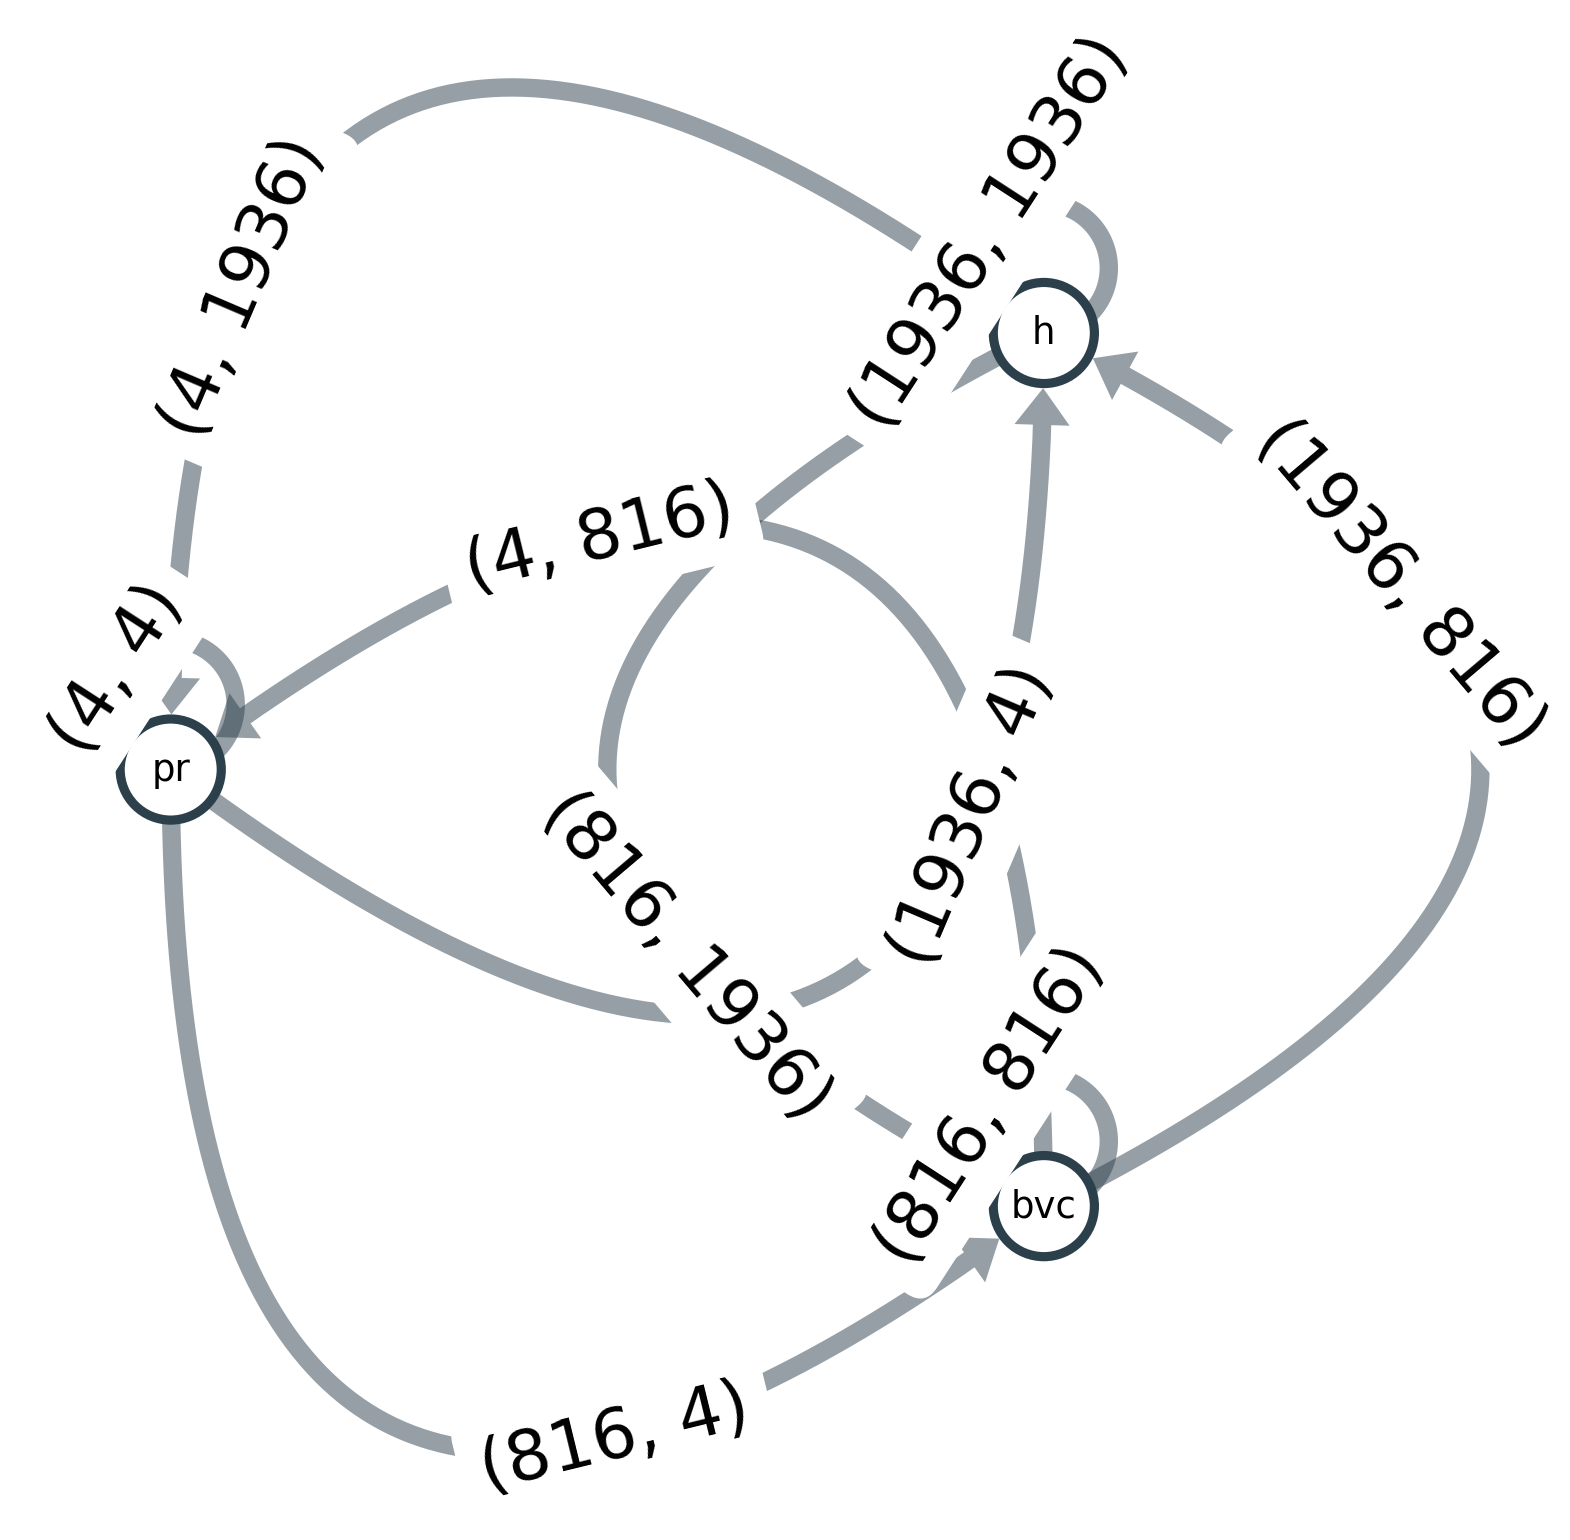

In [11]:
fig = mtl_weights.plot(scale=(.5, .5), edge_label_fontdict=dict(fontsize=50))

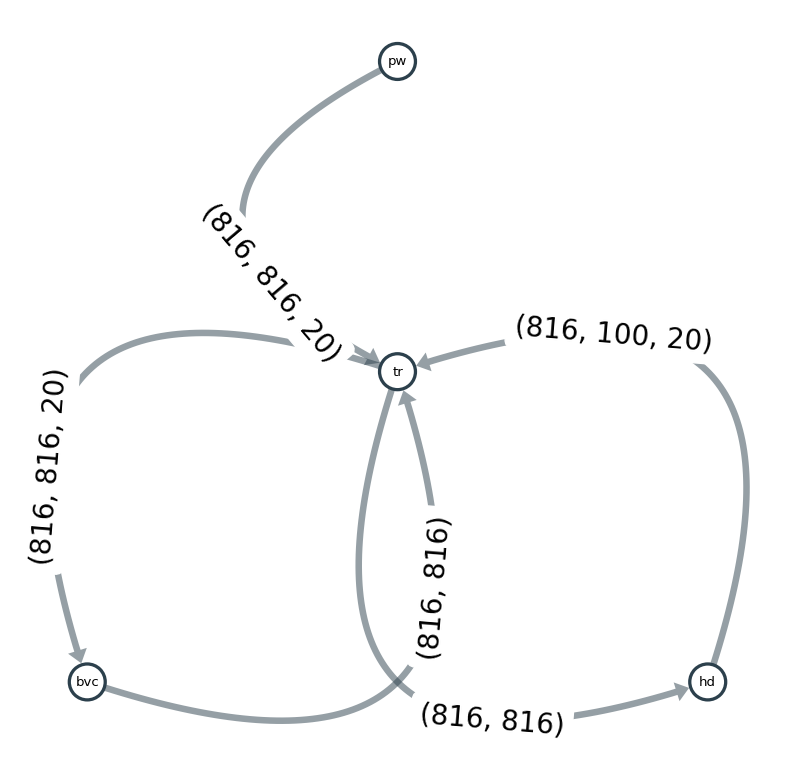

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
fig = tc_weights.plot(ax=ax, edge_label_fontdict=dict(fontsize=20))

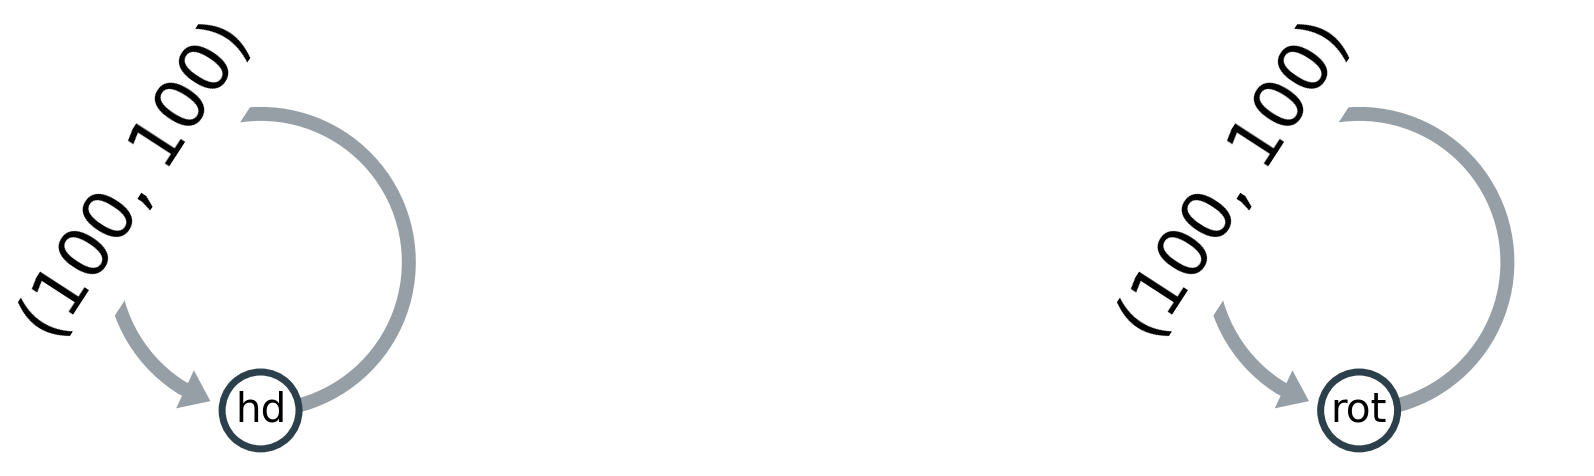

In [13]:
fig = hd_weights.plot(scale=(1.5, 1.5), edge_label_fontdict=dict(fontsize=50))

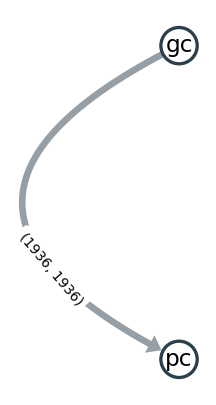

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = pc_weights.plot(ax=ax, scale=(.5, .5))

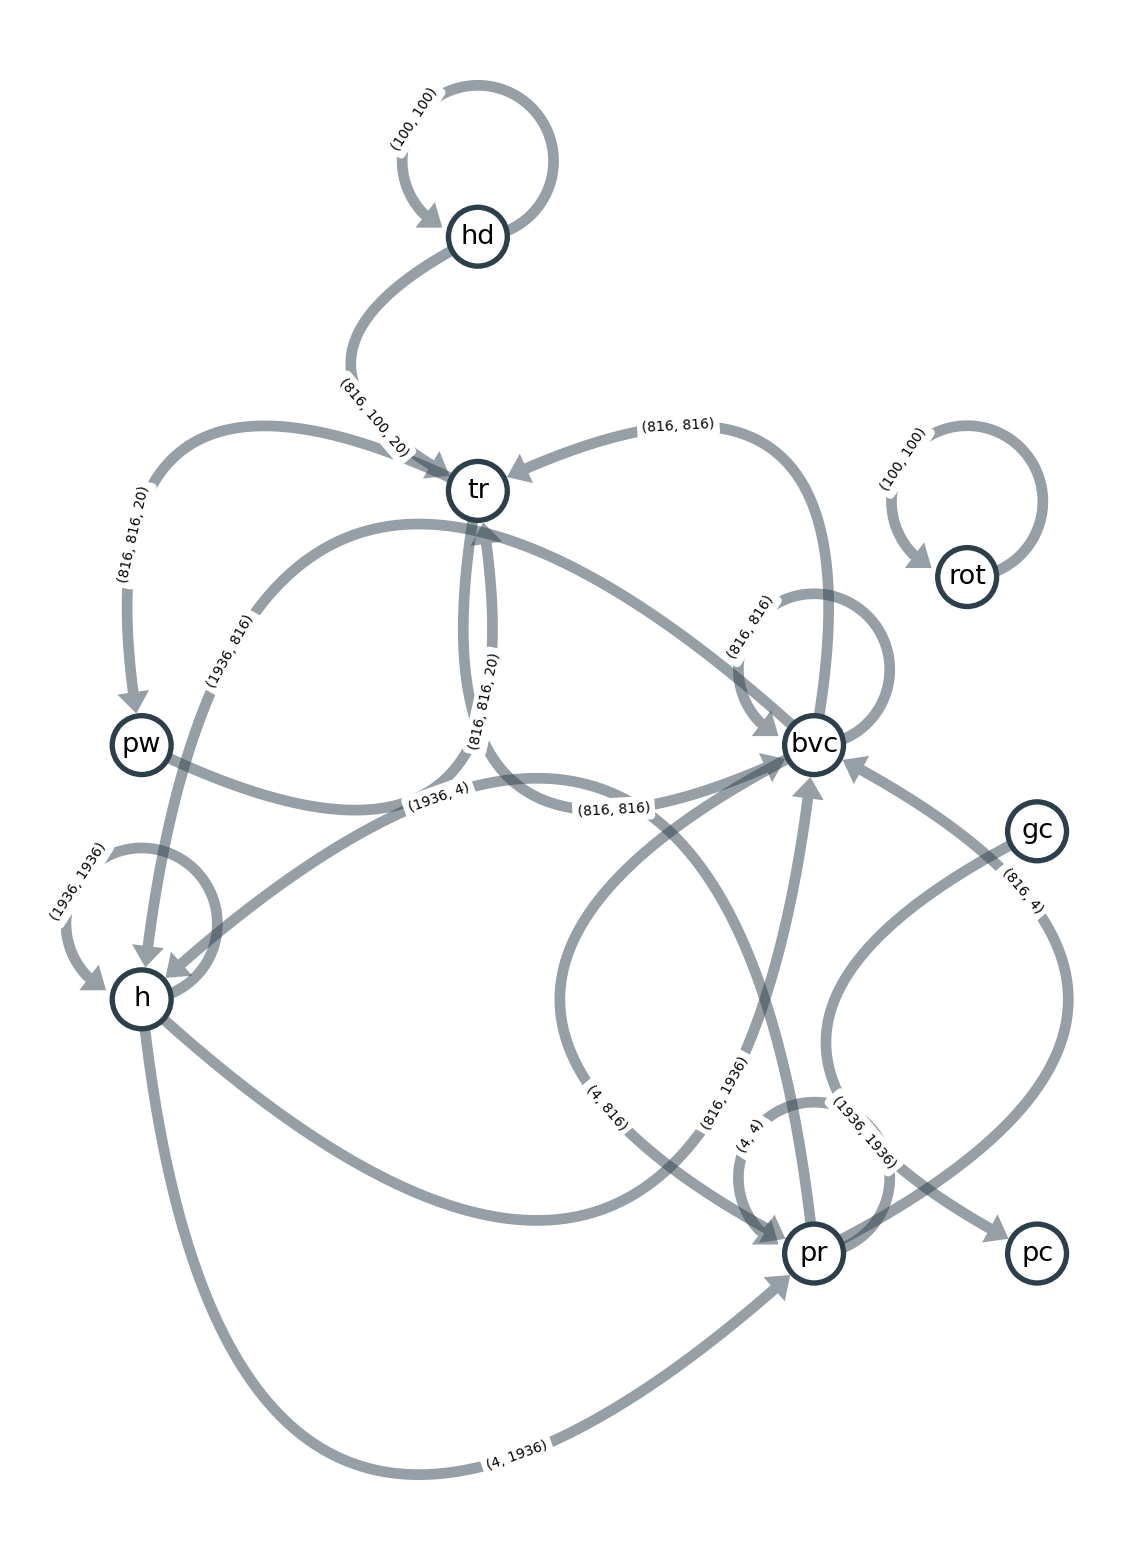

In [22]:
fig = (mtl_weights + tc_weights + hd_weights + pc_weights).plot()